# KNN Algorithm
KNN 알고리즘은 지도학습에 한 종류로 거리기반 분류분석 모델이다.<br>
기존 관측치의 Y값(class)가 존재한다는 점에서 비지도학습인 클러스터링과 차이가 있다.<br>
사용 사례) 이미지 처리, 글자 인식, 얼굴 인식, 추천 알고리즘, 유전자 데이터의 패턴인식, 암진단<br>


판별하고 싶은 데이터와 인접한 K개의 데이터를 찾아 해당 데이터 라벨이 다수인 범주로 데이터를 분류

## 장점
- 단순하고 효율적이다.
- 기저 데이터 분포에 대한 가정을 하지 않는다.
- 훈련 속도가 빠르다
- 수치 기반 데이터 분류 작업에서 성능이 우수하다

## 단점
- 모델을 생성하지 않아 특징과 클래스간 관계를 이해하는 데 제한적이다
- 적절한 K의 선택이 필요하다
- 데이터가 많아지면 분류단계가 느리다
- 명목 특징 및 누락 데이터를 위한 추가 처리가 필요하다

## 주의 사항
명목 데이터를 수치 형식을 변환할 때 더미코딩을 활용한다.
⇒ 표준화가 필요하다, 변수 값을 표준 범위로 재조정하기 위해 정규화를 적용한다.

- min-max normalization

- z-score standardization <br>
실무에서 주로 사용, 예측할 데이터셋에서 최솟값과 최대값이 범위를 벗어나는 경우가 생기기 때문

## Parameter
- **n_neighbors** = 5 : 근처에 특성을 파악할 데이터의 개수
- **weights** = 'uniform', ‘distance’ : uniform은 거리에 무관하게 가중치가 동일, distance라면 거리에 따라 다른 가중치를 갖는다.
- **algorithm** = ‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’ : auto는 자동으로 가장 적합한 algorithm을 찾아준다.
- **leaf_size** = int, default=30 BallTree나 KDTree 사용시 설정하며 Algorithm의 속도나 memory의 크기, 모델 성능에 영향을 미친다. 트리를 구성하는 잎의 크기
- **p** = int, default=2 Minkowski 지표의 전력 매개변수
    p=2 : Euclidean (L2 Norm) p=1 : Manhattan distance (L1 Norm)
    
- **metric** = 'minkowski' 거리 계산의 척도 minkowski, euclideam, manhalanobis
- **metric_params** = dict, default=None
- **n_jobs** = int, default=None : 학습에 사용할 CPU 코어의 수 -1이면 모든 코어 사용

## Library Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import scipy.stats as stats

## Data Load

In [2]:
dataPath = "/Users/yunhyeonchan/AI_Security_Project/Bot_Iot_Data_File/Entire_Dataset/"
data_orig = pd.read_csv(dataPath + "UNSW_2018_IoT_Botnet_Final_10_Best.csv", sep = ';')
data_orig = data_orig.drop(columns = ['Unnamed: 0'])
data_orig = data_orig.sample(50000)  # 약 300만개의 데이터를 다 학습하기에는 시간이 오래걸린다. 

In [3]:
ten_best_features = ['stddev','N_IN_Conn_P_SrcIP', 'min', 'state_number', 'mean', 'N_IN_Conn_P_DstIP',
       'drate', 'srate', 'max']  
# 기존의 ten_best_feature에서 'seq'는 제외하였다. 
# 이유는 seq는 numerical feature라고 판단하기 힘들 뿐더러 categorical Feature라고 하기에는 수가 너무 많았다. (index와 같은 값이다)
target_features = ['attack','category']

In [4]:
X = data_orig[ten_best_features]  # X : Feature들의 데이터 
y = data_orig[target_features]  # y : Target Feature 데이터

## 정규화 작업
KNN Algorism은 거리 기반 알고리즘이기 때문에 수치형 데이터들은 z-score standardization을 하였고, <br>
범주형 데이터들은 One-Hot Encoding을 진행하였다.

In [5]:
X_cols = list(X.columns)
X_cols.remove('state_number')  # 범주형 데이터인 state_number를 제외한 후 z-score standardization을 징행하였다.
X_cols

['stddev',
 'N_IN_Conn_P_SrcIP',
 'min',
 'mean',
 'N_IN_Conn_P_DstIP',
 'drate',
 'srate',
 'max']

### z-score standardization

In [6]:
for col in X_cols:
    col_data = X[col]
    scaled_col = stats.zscore(col_data)
    X[col] = scaled_col

### One-Hot-Encoding

In [7]:
X = pd.get_dummies(X, columns = ['state_number'])
X

,stddev,N_IN_Conn_P_SrcIP,min,mean,N_IN_Conn_P_DstIP,drate,srate,max,state_number_1,state_number_2,state_number_3,state_number_4,state_number_5,state_number_6,state_number_7,state_number_9
1791041,1.690877,0.343346,-0.684064,0.010760,0.413984,-0.015079,-0.021876,0.790339,0,0,1,0,0,0,0,0
448063,-1.105438,-0.768730,-0.684064,-1.466036,-1.573772,-0.015079,-0.021710,-1.616547,0,0,1,0,0,0,0,0
2015265,1.182873,0.714038,-0.577751,0.315513,0.413984,-0.015079,-0.019566,0.747575,1,0,0,0,0,0,0,0
1661913,-1.105438,-2.004370,-0.684064,-1.466036,0.413984,-0.015079,-0.022390,-1.616547,0,0,1,0,0,0,0,0
1028490,1.127865,0.714038,-0.684064,0.892799,0.413984,-0.015079,-0.018220,0.794127,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2164605,1.215415,0.714038,-0.684064,-0.545887,0.413984,-0.011964,-0.020235,0.544914,1,0,0,0,0,0,0,0
977910,-1.081828,0.714038,1.719597,0.883435,0.413984,-0.015079,-0.020247,0.314868,0,0,0,1,0,0,0,0
2781018,-0.215153,0.343346,1.348211,1.115560,0.413984,-0.015079,-0.013055,0.929177,0,0,0,1,0,0,0,0
2393696,0.803264,-2.045558,-0.684064,-0.043124,0.413984,-0.015079,-0.019783,0.184118,0,0,1,0,0,0,0,0


## Target Data 정규화
Target data는 attack과 category로 이루어져 있다. 
target의 feature가 하나 이상일 경우 출력값이 복잡해지는 이유로 attack과 category를 하나로 합쳤다.

In [8]:
encoder = LabelEncoder()
y['target'] = encoder.fit_transform(y['category'])
y

,attack,category,target
1791041,1,DDoS,0
448063,1,DoS,1
2015265,1,DDoS,0
1661913,1,DDoS,0
1028490,1,DoS,1
...,...,...,...
2164605,1,DDoS,0
977910,1,DoS,1
2781018,1,DDoS,0
2393696,1,DDoS,0


In [9]:
y['target'] = y['target'] + y['attack'] * 10
y['target'].value_counts()

10    26372
11    22334
13     1289
2         5
Name: target, dtype: int64

## Model training

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score

In [11]:
x_train, x_test, y_train, y_test = train_test_split(X, y['target'], random_state=42)

In [12]:
clf = KNeighborsClassifier()
clf.fit(x_train, y_train)
prediction = clf.predict(x_test)
print(f"clf.score             : {clf.score(x_train, y_train):.3}")
print(f"(pred == y_test) score: :{(prediction==y_test).mean():.3}")
print(f"cross_val_score       : {cross_val_score(clf, x_train, y_train, cv=10).mean():.3}")

clf.score             : 0.99
(pred == y_test) score: :0.984
cross_val_score       : 0.986


In [13]:
train_acc = []
test_acc = []

for n in range(1,15):
    clf = KNeighborsClassifier(n_jobs=-1, n_neighbors=n)
    clf.fit(x_train, y_train)
    prediction = clf.predict(x_test)
    train_acc.append(clf.score(x_train, y_train))
    test_acc.append((prediction==y_test).mean())

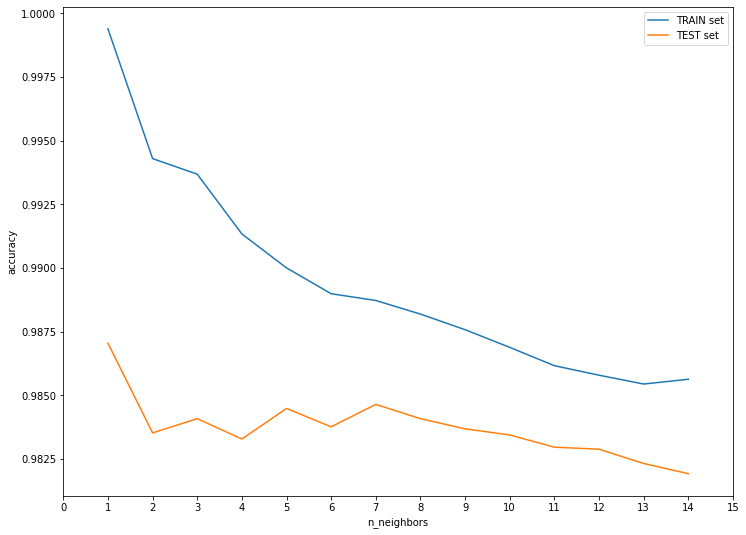

In [14]:
plt.figure(figsize=(12, 9))
plt.plot(range(1, 15), train_acc, label='TRAIN set')
plt.plot(range(1, 15), test_acc, label='TEST set')
plt.xlabel("n_neighbors")
plt.ylabel("accuracy")
plt.xticks(np.arange(0, 16, step=1))
plt.legend()
plt.show()